In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import get_window
from numba import njit

# Main functions

In [182]:
# fsle and fsrv with uncertainties from bootstrap method
@njit
def bootstrap_fsle_fsrv(xtra,ytra,u,v,pairs_to_monitor_original,dt,R0,r=1.2,nbs=1000):
    #print(nbs)
    # fsle
    # number of thresholds for FSLE
    Nthr=45
    ntzeros=int(len(xtra))
    # thresholds for FSLE
    thresh=np.zeros(Nthr)
    thresh = [R0 * r**k for k in range(Nthr)]
    lambda_xp=np.zeros((Nthr,nbs))
    fsrv_xp=np.zeros((Nthr,nbs))
    nstat_fsle_xp=np.zeros((Nthr,nbs))
    # arrays for statistics on bootstrap samples
    pairs_to_monitor = pairs_to_monitor_original

    for ibs in range(nbs):
        nsample=len(pairs_to_monitor_original)
        d2=np.zeros((nsample,ntzeros))
        kpairold_xp=np.zeros(nsample)
        kpair_xp=np.zeros(nsample)
        timeold_xp=np.zeros(nsample)
        tau_xp=np.zeros(Nthr)
        fsrv_ibs=np.zeros(Nthr)
        # if ibs=0 then use original indices
        if ibs!=0:
            n_samples=pairs_to_monitor_original.shape[0]
            # Randomly select row indices with replacement
            indices = np.random.choice(pairs_to_monitor_original.shape[0], size=n_samples, replace=True)
            pairs_to_monitor = pairs_to_monitor_original[indices]
    
        # print("bootstrap sample ibs=%d" %ibs)
        # loop on time
        for ifr in range(ntzeros):
            it=ifr*dt
            for ip,pair in enumerate(pairs_to_monitor):
                d2[ip,ifr]=(xtra[ifr,pair[0]]-xtra[ifr,pair[1]])**2+(ytra[ifr,pair[0]]-ytra[ifr,pair[1]])**2
                # fsle
                d=np.sqrt(d2[ip,ifr])
                # Lagrangian 2nd order spatial structure function (fsrv) 
                v2 = (u[ifr,pair[0]]-u[ifr,pair[1]])**2 + (v[ifr,pair[0]]-v[ifr,pair[1]])**2
                kpair_xp[ip]=int(1./np.log(r)*np.log(d/R0))
                if kpair_xp[ip]>kpairold_xp[ip]:
                    tau_xp[int(kpairold_xp[ip])]=tau_xp[int(kpairold_xp[ip])]+it-timeold_xp[ip]
                    nstat_fsle_xp[int(kpairold_xp[ip]),ibs]=nstat_fsle_xp[int(kpairold_xp[ip]),ibs]+1
                    fsrv_ibs[int(kpairold_xp[ip])]=fsrv_ibs[int(kpairold_xp[ip])]+v2
                    kpairold_xp[ip]=kpair_xp[ip]
                    timeold_xp[ip]=it

        for k in range(Nthr):
            if nstat_fsle_xp[k,ibs] != 0:
                lambda_xp[k,ibs]=np.log(r)/(tau_xp[k]/nstat_fsle_xp[k,ibs])
                fsrv_xp[k,ibs]=fsrv_ibs[k]/(nstat_fsle_xp[k,ibs])
    
    return thresh, lambda_xp, fsrv_xp, nstat_fsle_xp


# pairs to monitor
def pmonitor(x,y, R0,iicc_flag):
    #print('num_pairs %d' %num_pairs)
    monitor=[]
    for particle in range(len(x)):
        #print('particle %d'%particle)
        for forward in range(particle+1,len(x)):
            #print('forward %d'%forward)
            temp_separation=((x[particle]-x[forward])**2+(y[particle]-y[forward])**2)**0.5
            if temp_separation <= R0:
                monitor.append([particle,forward])

    monitor=np.array(monitor)
    ###### 
    # if localized i.c.
    if iicc_flag==0:
        indices = np.random.choice(monitor.shape[0], size=num_pairs, replace=False)
        scra = monitor[indices]
        monitor = scra
    #######
    
    return monitor

#finite-difference derivative (for Lagrangian velocities)
@njit(nopython=True)
def finite_difference_time_derivative(array, h, method='central'):
    """
    Compute the finite difference approximation of the time derivative for each spatial position (x).
    
    Parameters:
        array (2D numpy array): The array where the first dimension is time (t) and the second is space (x).
        h (float): The time step size.
        method (str): The method to use: 'forward', 'backward', or 'central' (default is 'central').
        
    Returns:
        2D numpy array: The derivative of the input array with respect to time at each position (t, x).
    """
    nt, nx = array.shape
    derivative = np.zeros_like(array)

    for j in range(nx):
        for i in range(1, nt-1):  # Central difference, avoid boundary points
            if method == 'central':
                derivative[i, j] = (array[i + 1, j] - array[i - 1, j]) / (2 * h)
            elif method == 'forward':
                if i < nt - 1:
                    derivative[i, j] = (array[i + 1, j] - array[i, j]) / h
            elif method == 'backward':
                if i > 0:
                    derivative[i, j] = (array[i, j] - array[i - 1, j]) / h
    
    # Handle the boundaries
    if method == 'forward':
        for j in range(nx):
            derivative[0, j] = (array[1, j] - array[0, j]) / h  # Forward at the start
            derivative[nt-1, j] = (array[nt-1, j] - array[nt-2, j]) / h  # Backward at the end
    elif method == 'backward':
        for j in range(nx):
            derivative[0, j] = (array[1, j] - array[0, j]) / h  # Forward at the start
            derivative[nt-1, j] = (array[nt-1, j] - array[nt-2, j]) / h  # Backward at the end
    elif method == 'central':
        for j in range(nx):
            derivative[0, j] = (array[1, j] - array[0, j]) / h  # Forward at the start
            derivative[nt-1, j] = (array[nt-1, j] - array[nt-2, j]) / h  # Backward at the end
    
    return derivative


# velocity field and one AB3 step in time
@njit
def update_particles_cellular(particles_x, particles_y, u1, v1, u2, v2, tt, ddtt):

    u = np.zeros_like(particles_x)
    v = np.zeros_like(particles_y)
    
    for i in range(n_c):
        u_temp = (
                alpha_c[i] 
                * np.sin(k_c[i] * (particles_x - epsilon_c[i] * np.sin(omega_c[i] * tt))) 
                * np.cos(k_c[i] * (particles_y - epsilon_c[i] * np.sin(omega_c[i] * tt)))
            )
        v_temp = (
                -alpha_c[i]  
                * np.cos(k_c[i] * (particles_x - epsilon_c[i] * np.sin(omega_c[i] * tt))) 
                * np.sin(k_c[i] * (particles_y - epsilon_c[i] * np.sin(omega_c[i] * tt)))
            )
        u += u_temp
        v += v_temp
    
    # First 2 steps as Euler
    if tt//ddtt <= 2:
        u1 = u
        v1 = v
        u2 = u
        v2 = v        
        
    particles_x = particles_x + (ddtt/12)*(23*u - 16*u1 +5*u2)
    particles_y = particles_y + (ddtt/12)*(23*v - 16*v1 +5*v2)
    
    return particles_x, particles_y, u, v

# time loop
@njit
def generate_flow(t_final,dt_in,iicc_flag):

    num_steps = int(t_final / dt_in)
    #print(num_steps)

    ###############################################
    # Initial condition   
    particles_x = np.empty(num_particles)
    particles_y = np.empty(num_particles)
    
    particle_positions_cellular_x = np.empty((num_steps,num_particles))
    particle_positions_cellular_y = np.empty((num_steps,num_particles))

    # ic_flag==1 : uniform ic
    # ic_flag==0 : localized ic
    if iicc_flag == 1 :
        ######################
        # Initialize particle pairs randomly 
        # uniform distribution
        # pairs with initial distance R0 and random orientation
        for i in range(num_pairs):
            x0 = np.random.uniform(0, L_c[0])
            y0 = np.random.uniform(0, L_c[0])
            theta = np.random.uniform(0, 2 * np.pi)
            dx = initial_separation * np.cos(theta)
            dy = initial_separation * np.sin(theta)
            particles_x[2 * i] = x0
            particles_y[2 * i] = y0
            particles_x[2 * i + 1] = x0 + dx
            particles_y[2 * i + 1] = y0 + dy
    else :
        ######################
        # Localized initial condition
        for i in range(num_particles):
            rr = np.random.uniform(0, initial_separation)
            theta = np.random.uniform(0, 2*np.pi)
            particles_x[i] = x0off + rr * np.cos(theta)
            particles_y[i] = y0off + rr * np.sin(theta)           
        ######################
        
    particle_positions_cellular_x[0,:] = np.copy(particles_x)
    particle_positions_cellular_y[0,:] = np.copy(particles_y)

    particle_u_cellular = np.zeros_like(particle_positions_cellular_x)
    particle_v_cellular = np.zeros_like(particle_positions_cellular_y)
    
    
    ###############################################
    # Advect particles in time and store their positions 
        
    for step in range(1, num_steps):
        t = step * dt_in
        #print(step)

        particles_x, particles_y, u, v = update_particles_cellular(particle_positions_cellular_x[step-1,:], 
                                                                    particle_positions_cellular_y[step-1,:],
                                                                    particle_u_cellular[step-1,:],
                                                                    particle_v_cellular[step-1,:],
                                                                    particle_u_cellular[step-2,:],
                                                                    particle_v_cellular[step-2,:],
                                                                    t, 
                                                                    dt_in)
        
        particle_positions_cellular_x[step,:]=np.copy(particles_x)
        particle_positions_cellular_y[step,:]=np.copy(particles_y)
        particle_u_cellular[step,:]=np.copy(u)
        particle_v_cellular[step,:]=np.copy(v)    

    return particle_positions_cellular_x, particle_positions_cellular_y, particle_u_cellular, particle_v_cellular

# relative dispersion vs time
@njit
def relative_disperion(x,y,pairs):
    frames = x.shape[0]
    relative_disperion = np.zeros(frames)
    for ifr in range(frames):
        p1 = pairs[:,0]
        p2 = pairs[:,1]
        x1 = np.take(x[ifr,:],p1)
        y1 = np.take(y[ifr,:],p1)
        x2 = np.take(x[ifr,:],p2)
        y2 = np.take(y[ifr,:],p2)
        relative_disperion[ifr]=np.mean((x2-x1)**2+(y2-y1)**2)
    return relative_disperion

# kurtosis vs time
@njit
def kurtosis(x,y,pairs):
    frames = x.shape[0]
    ku = np.zeros(frames)
    for ifr in range(frames):
        p1 = pairs[:,0]
        p2 = pairs[:,1]
        x1 = np.take(x[ifr,:],p1)
        y1 = np.take(y[ifr,:],p1)
        x2 = np.take(x[ifr,:],p2)
        y2 = np.take(y[ifr,:],p2)
        ku[ifr]=np.mean(((x2-x1)**2+(y2-y1)**2)**2)/(np.mean((x2-x1)**2+(y2-y1)**2))**2
    return ku
        

c:\Users\aymer\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# Main parameters

In [183]:
# Main parameters

###############################################
# Flow parameters
# Define parameters for the cellular flow
nu_c = 2.0
h_c = 1.0/3.0 
# Number of modes
n_c = 1 

# For all modes
epsilon_c_denom = 4.0
L_c = np.zeros(n_c)
alpha_c = np.zeros(n_c)
k_c = np.zeros(n_c)
epsilon_c = np.zeros(n_c)
omega_c = np.zeros(n_c)
    
L_c[0]=100.
alpha_c[0]=10.
k_c[0]=2.0*np.pi/L_c[0]
epsilon_c[0]=L_c[0]/epsilon_c_denom 
omega_c[0]=np.pi*alpha_c[0]/L_c[0]
    
for i in range(1,n_c):
    L_c[i]=(L_c[0]*nu_c**(1-(i+1)))
    alpha_c[i]=(alpha_c[0]*(L_c[i]/L_c[0])**h_c)
    k_c[i]=(2.0*np.pi/L_c[i])
    epsilon_c[i]=(L_c[i]/epsilon_c_denom)
    omega_c[i]=(np.pi*alpha_c[i]/L_c[i])
    
###############################################
# Uniform or Localized ic
# ic_flag==1 : uniform ic; ic_flag==0 : localized ic
ic_flag=1
initial_separation=0.001 * L_c[0]
x0off=1.
y0off=2.

# Number of pairs
# With localized ic: true number of pairs > num_pairs
num_pairs = 20 ###
num_particles = 2 * num_pairs

# simulation time
dt = 0.1
t_final = 400


# Main Loop

In [184]:
# generate trajectories
particle_positions_cellular_x, particle_positions_cellular_y, particle_u_cellular, particle_v_cellular = generate_flow(t_final,dt,ic_flag)


# Lagrangian statistics

In [185]:
# Lagrangian statistics

# arrays for Lagrangian velocities (for fsrv)
lagr_vel_u = np.empty((int(t_final / dt),num_particles))
lagr_vel_v = np.empty((int(t_final / dt),num_particles))

# arrays (lists) for Lagrangian indicators
fsle = []
fsrv = []

rel_disp = []
ku = []

# R0>initial_separation to take all pairs at init. dist.<= R0
R0=initial_separation*1.1
# select pairs to consider for statistics
pairs_to_monitor_original=pmonitor(particle_positions_cellular_x[0,:],particle_positions_cellular_y[0,:],R0, ic_flag)

lagr_vel_u = finite_difference_time_derivative(particle_positions_cellular_x, dt, method='central')
lagr_vel_v = finite_difference_time_derivative(particle_positions_cellular_x, dt, method='central')

# compute fsle and fsrv
thresh, lambda_xp, fsrv_xp, nstat_fsle_xp= bootstrap_fsle_fsrv(particle_positions_cellular_x,
                                                             particle_positions_cellular_y,
                                                             lagr_vel_u,
                                                             lagr_vel_v,
                                                             pairs_to_monitor_original,
                                                             dt,
                                                             R0,
                                                             r=1.2,
                                                             nbs=1)

# compute rlative dispersion and kurtosis 
rel_disp.append(relative_disperion(particle_positions_cellular_x,particle_positions_cellular_y,pairs_to_monitor_original))
ku.append(kurtosis(particle_positions_cellular_x,particle_positions_cellular_y,pairs_to_monitor_original))


## Plot

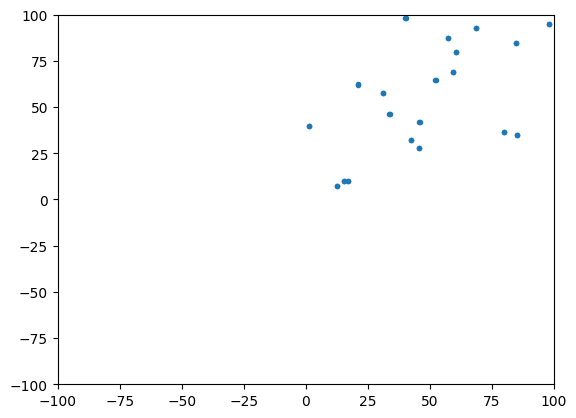

In [186]:
# plot initial particle distribution

#print(initial_separation)
#print(num_pairs)

xm=-L_c[0]
xM=L_c[0]
ym=-L_c[0]
yM=L_c[0]

# plot initial particle distribution
plt.plot(particle_positions_cellular_x[0,:],particle_positions_cellular_y[0,:], '.')
plt.xlim(xm,xM)
plt.ylim(ym,yM)
plt.show()

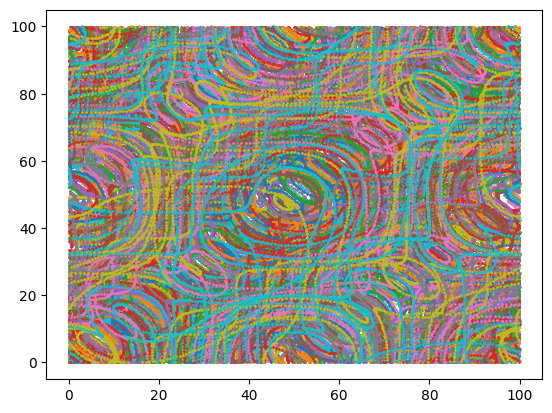

In [187]:
# Plot the trajectories 

# Here it is assumed that we are simulating a cellular flow with one mode only
fig, ax = plt.subplots()
for ix in range(num_particles):
    plt.scatter(particle_positions_cellular_x[:,ix]%L_c[0], particle_positions_cellular_y[:,ix]%L_c[0],s=1)
plt.show()

Velocity Spectrum 

C:\Users\aymer\AppData\Local\Temp\ipykernel_9716\3541690008.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_u[:,i]= np.fft.fft(u_windowed[:,i])
C:\Users\aymer\AppData\Local\Temp\ipykernel_9716\3541690008.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_v[:,i]=np.fft.fft(v_windowed[:,i])


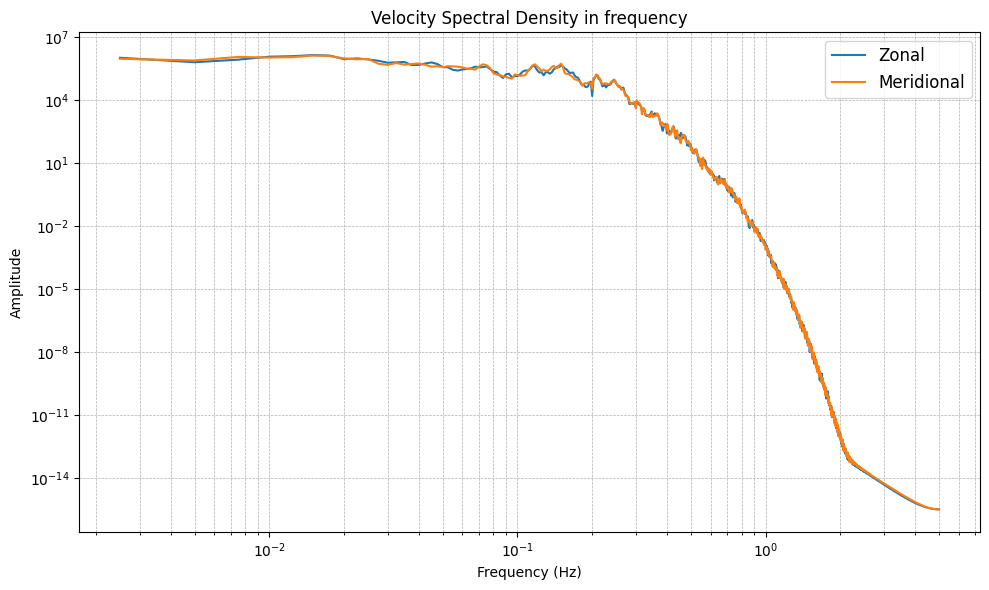

In [ ]:
# Compute and plot the velocity spectrum in frequency 

fs = 1/dt # Sampling frequency  
N = int(t_final / dt)

window = get_window('blackman', N)

u_windowed=np.zeros((N,num_particles))
fft_u=np.zeros((N,num_particles))
v_windowed=np.zeros((N,num_particles))
fft_v=np.zeros((N,num_particles))

for i in range(num_particles):
    u_windowed[:,i]= particle_u_cellular[:,i] * window
    fft_u[:,i]= np.fft.fft(u_windowed[:,i])
    v_windowed[:,i]=particle_v_cellular[:,i]*window
    fft_v[:,i]=np.fft.fft(v_windowed[:,i])

# Spectrum for u

frequencies_u= np.fft.fftfreq(N, dt)
u_freq=frequencies_u[1:N//2]
u_spec_particles = np.abs(fft_u[1:N // 2])**2
u_spec=np.sum(u_spec_particles,axis=1)/num_particles

# Spectrum for v

frequencies_v=np.fft.fftfreq(N, dt)
v_freq=frequencies_v[1:N//2]
v_spec_particles=np.abs(fft_v[1:N // 2])**2
v_spec=np.sum(v_spec_particles,axis=1)/num_particles


# Velocity Spectrum 

vel_freq=u_freq
vel_spec=np.sqrt(u_spec+v_spec)

# Plots 

plt.figure(figsize=(10, 6))

#plt.loglog(vel_freq,vel_spec)

plt.loglog(u_freq,u_spec,label="Zonal")
plt.loglog(v_freq,v_spec,label="Meridional")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Density')
plt.title('Velocity Spectral Density in frequency')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  
plt.legend(fontsize=12)  
plt.tight_layout()



#print(np.sum(positive_fft_u)/N*2,np.sum(u_windowed**2))


(0.001, 10)

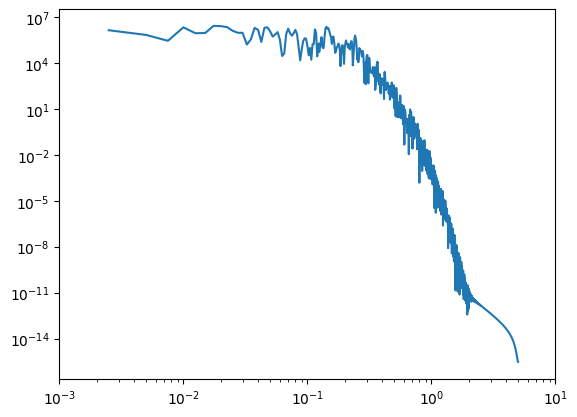

In [203]:
U=np.copy(particle_u_cellular[:,6])
#plt.plot(U)

fs = 1/dt # Sampling frequency  
N = int(t_final / dt)

window = get_window('blackman', N)
u_windowed = U * window
#plt.plot(u_windowed)

fft_u= np.fft.fft(u_windowed)
frequencies_u = np.fft.fftfreq(N, dt)
positive_fft_u = np.abs(fft_u[:N // 2])**2
normalization_factor = np.sum(window**2) / N
positive_fft_u_normalized = positive_fft_u / normalization_factor

plt.loglog(frequencies_u[1:N//2],positive_fft_u[1:])
#print(np.sum(positive_fft_u)/N*2,np.sum(u_windowed**2))
plt.xlim(1e-3,10)

In [198]:
print(frequencies_u[np.argmax(u_spec)])
print(omega_c)

0.0125
[0.31415927]


### Arrays for bootstrap statistics

In [192]:
# preparing fsle and fsrv arrays for plots

thresh=np.array(thresh)

# variables for confidence intervals for fsle and fsrv
cint_max=95
cint_min=5

lambda_xp_cimax=np.zeros(np.shape(lambda_xp)[0])
lambda_xp_cimin=np.zeros(np.shape(lambda_xp)[0])
fsrv_xp_cimax=np.zeros(np.shape(fsrv_xp)[0])
fsrv_xp_cimin=np.zeros(np.shape(fsrv_xp)[0])

# compute mean (over bootstrap samples) fsle and fsrv
fsle=np.mean(lambda_xp,1)
fsrv=np.mean(fsrv_xp,1)

# compute confidence intervals (over bootstrap samples) for fsle and fsrv
lambda_xp_cimin=np.percentile(lambda_xp,cint_min,axis=1)
lambda_xp_cimax=np.percentile(lambda_xp,cint_max,axis=1)
fsrv_xp_cimin=np.percentile(fsrv_xp,cint_min,axis=1)
fsrv_xp_cimax=np.percentile(fsrv_xp,cint_max,axis=1)



### FSLE

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\l'
C:\Users\aymer\AppData\Local\Temp\ipykernel_9716\3465713730.py:12: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$\delta$')
C:\Users\aymer\AppData\Local\Temp\ipykernel_9716\3465713730.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\lambda(\delta)$')


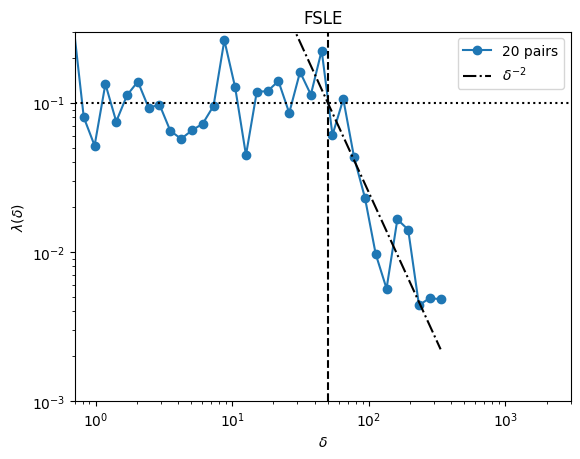

In [193]:
# plot fsle vs separation distance

plt.loglog(thresh[fsle!=0],fsle[fsle!=0],'-o',label=f'{num_pairs} pairs')
#plt.loglog(thresh[fsle!=0],lambda_xp_cimax[fsle!=0],'-b')
#plt.loglog(thresh[fsle!=0],lambda_xp_cimin[fsle!=0],'-b')
# nonlocal regime prediction
plt.axhline(y=alpha_c[0]/L_c[0],color='black',linestyle='dotted')
# diffusive regime prediction
plt.loglog(thresh,250*thresh**-2,color='black',linestyle='dashdot',label=r'$\delta^{-2}$')
plt.axvline(x=L_c[0]/2,color='black',linestyle='dashed')

plt.xlabel('$\delta$')
plt.ylabel('$\lambda(\delta)$')
plt.xlim(7e-1,3e3)
plt.ylim(1e-3,3e-1)
plt.title('FSLE')
plt.legend()
# plt.savefig('./FSLE.pdf')
plt.show()

### FSRV

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aymer\AppData\Local\Temp\ipykernel_9716\63843995.py:12: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$\delta$')


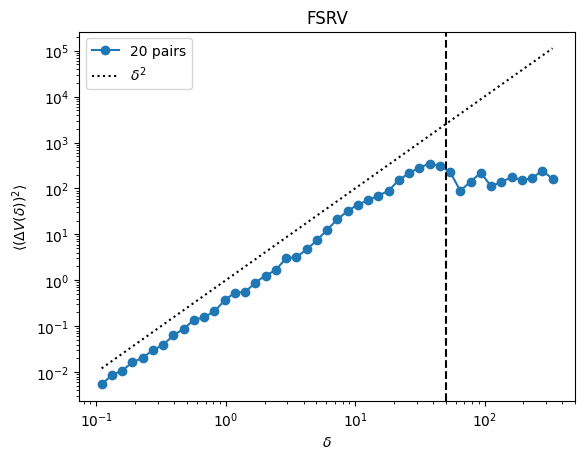

In [194]:
# plot fsrv vs separation distance


plt.loglog(thresh[fsrv!=0],fsrv[fsrv!=0],'-o',label=f'{num_pairs} pairs')
#plt.loglog(thresh[fsle!=0],fsrv_xp_cimax[fsle!=0],'-b')
#plt.loglog(thresh[fsle!=0],fsrv_xp_cimin[fsle!=0],'-b')
# nonlocal regime prediction
plt.loglog(thresh,thresh**2,color='black',linestyle='dotted',label=r'$\delta^2$')
plt.axvline(x=L_c[0]/2,color='black',linestyle='dashed')

plt.title('FSRV')
plt.xlabel('$\delta$')
# plt.ylim(30,1e3)
plt.ylabel(r'$\langle (\Delta V(\delta))^2 \rangle$')
plt.legend()
plt.show()

### Relative dispersion

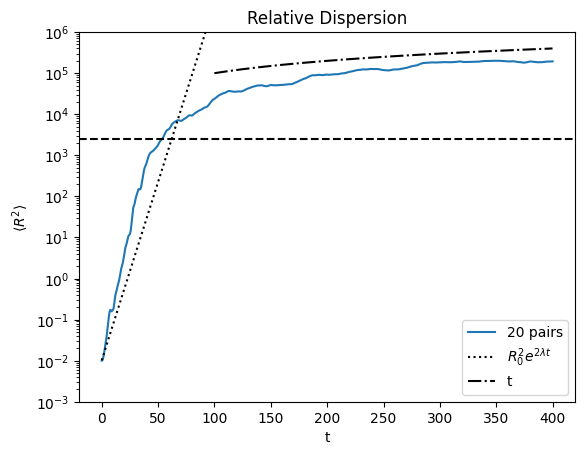

In [195]:
# plot relative dispersion vs time (exponential regime recovered in localized IC)

tt=dt*np.arange(1,int(t_final/dt)+1)
rel_disp=np.array(rel_disp)

#plt.loglog(tt,rel_disp[0,:],'-',label=f'{num_pairs} pairs')
#plt.loglog(tt,rel_disp[0,0]*np.exp(2*alpha_c[0]/L_c[0]*tt),color='black',linestyle='dotted',label=r'$R_0e^{2\lambda t}$')
plt.semilogy(tt,rel_disp[0,:],'-',label=f'{num_pairs} pairs')
# nonlocal regime prediction
plt.semilogy(tt,rel_disp[0,0]*np.exp(2*alpha_c[0]/L_c[0]*tt),color='black',linestyle='dotted',label=r'$R_0^2e^{2\lambda t}$')
# diffusive regime prediction
plt.semilogy(tt[-1-3000:-1],1000*tt[-1-3000:-1],color='black',linestyle='dashdot',label=r't')
plt.axhline(y=(L_c[0]/2)**2,color='black',linestyle='dashed')

plt.ylim(1e-3,1e6)
plt.title('Relative Dispersion')
plt.xlabel('t')
plt.ylabel(r'$\langle R^2 \rangle$')
plt.legend()
plt.show()


### Kurtosis

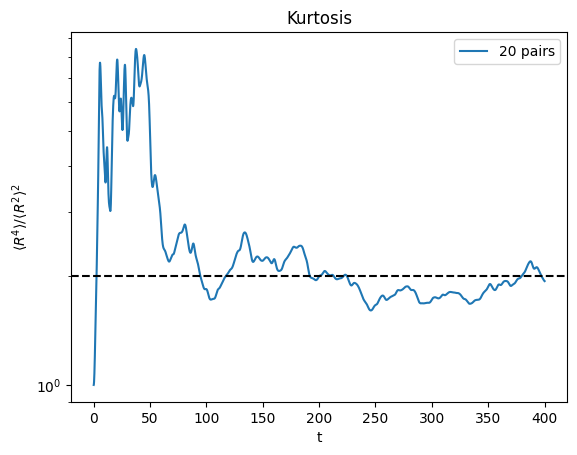

In [196]:
# plot kurtosis vs time 

ku=np.array(ku)

plt.semilogy(tt,ku[0,:],'-',label=f'{num_pairs} pairs')
plt.axhline(y=2, color='black',linestyle='dashed')

plt.title('Kurtosis')
plt.xlabel('t')
plt.ylabel(r'$\langle R^4 \rangle$/$\langle R^2 \rangle^2$')
plt.legend()
plt.show()